# The QNLP Pipeline for Twitter Sentiment Analysis
## 1. Load the preprocessed data

In [1]:
import collections
import pickle
import warnings
warnings.filterwarnings("ignore")
import os
from random import shuffle
import random
from discopy.tensor import Tensor
from discopy import Word
from discopy.rigid import Functor
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from jax import numpy as np
import numpy
from lambeq import AtomicType, IQPAnsatz, remove_cups, NumpyModel, spiders_reader
from lambeq import BobcatParser, TreeReader, cups_reader, DepCCGParser
from lambeq import Dataset
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import TketModel
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.width', 1000)
pd.options.display.max_colwidth=80
print(os.getcwd())
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
BATCH_SIZE = 30
EPOCHS = 100
SEED = 0

TRAIN_INDEX_RATIO = 0.08
VAL_INDEX_RATIO = TRAIN_INDEX_RATIO + 0.01
TEST_INDEX_RATIO = VAL_INDEX_RATIO + 0.01

assert TEST_INDEX_RATIO <= 1

def load_pickled_dict_to_df(filename):
    saved_dict = pickle.load(open(filename, 'rb'))
    df =  pd.DataFrame.from_dict(saved_dict)
    df =  df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    return df

cleaned_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data.pkl')
cleaned_lemmatized_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data_lematize.pkl')
cleaned_lemmatized_stemmed_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data_stem_lematize.pkl')

cleaned_qnlp = load_pickled_dict_to_df(cleaned_qnlp_filename)

cleaned_lemmatized_qnlp = load_pickled_dict_to_df(cleaned_lemmatized_qnlp_filename)

cleaned__lemmatized_stemmed_qnlp = load_pickled_dict_to_df(cleaned_lemmatized_stemmed_qnlp_filename)

/app


In [2]:
cleaned_qnlp.head()

,data,label,target
0,this isn t one hour i am still crushing all version of combat imperial warfa...,"[0, 1]",Positive
1,to my home depot friend this place is very close to work and it is very inex...,"[0, 1]",Positive
2,what a cutie unk unk check out my screenshot from world of,"[0, 1]",Positive
3,battlefield war v is a boring mess,"[1, 0]",Negative
4,the flatline of red dead redemption pic twitter com,"[1, 0]",Negative


In [3]:
cleaned_qnlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4084 entries, 0 to 4083
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    4084 non-null   object
 1   label   4084 non-null   object
 2   target  4084 non-null   object
dtypes: object(3)
memory usage: 95.8+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

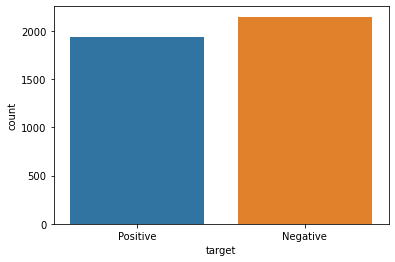

In [4]:
sns.countplot(x = "target", data = cleaned_qnlp)

In [5]:
cleaned_lemmatized_qnlp.head()

,data,label,target
0,this isn t one hour i am still crushing all version of combat imperial warfa...,"[0, 1]",Positive
1,to my home depot friend this place is very close to work and it is very inex...,"[0, 1]",Positive
2,what a cutie unk unk check out my screenshot from world of,"[0, 1]",Positive
3,battlefield war v is a boring mess,"[1, 0]",Negative
4,the flatline of red dead redemption pic twitter com,"[1, 0]",Negative


In [6]:
cleaned_lemmatized_qnlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4084 entries, 0 to 4083
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    4084 non-null   object
 1   label   4084 non-null   object
 2   target  4084 non-null   object
dtypes: object(3)
memory usage: 95.8+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

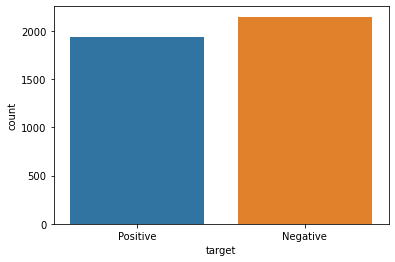

In [7]:
sns.countplot(x='target', data = cleaned_lemmatized_qnlp)

In [8]:
cleaned__lemmatized_stemmed_qnlp.head()

,data,label,target
0,i realli don t know whi i play fortnit it is so bad,"[0, 1]",Positive
1,fantast day today congratul to gearboxoffici and borderland stori make you f...,"[0, 1]",Positive
2,microsoft had a major outag today,"[1, 0]",Negative
3,thi wa better,"[1, 0]",Negative
4,p the player are part of own observ no wonder they are back to work,"[1, 0]",Negative


In [9]:
cleaned__lemmatized_stemmed_qnlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4084 entries, 0 to 4083
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    4084 non-null   object
 1   label   4084 non-null   object
 2   target  4084 non-null   object
dtypes: object(3)
memory usage: 95.8+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

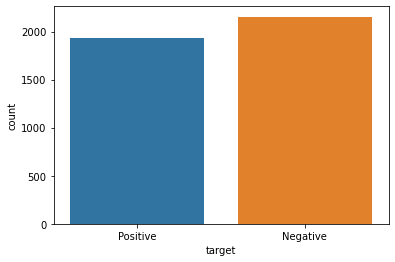

In [10]:
sns.countplot(x='target', data = cleaned__lemmatized_stemmed_qnlp)

## 2. Train QNLP Models for Different-Preprocessed Data
Since the limited parsing speed, we'll only use a fraction of our data.

In [11]:
parser = BobcatParser(verbose='text')
NUM_DATA = 4084
def create_diagrams_and_labels(total_df):
    total_text = total_df['data'].tolist()
    total_labels = total_df['label'].tolist()
    train_diagrams = parser.sentences2diagrams(total_text[:round(NUM_DATA*TRAIN_INDEX_RATIO)])
    train_labels = total_labels[:round(NUM_DATA*TRAIN_INDEX_RATIO)]
    dev_diagrams = parser.sentences2diagrams(total_text[round(NUM_DATA*TRAIN_INDEX_RATIO):round(NUM_DATA*VAL_INDEX_RATIO)])
    dev_labels = total_labels[round(NUM_DATA*TRAIN_INDEX_RATIO):round(NUM_DATA*VAL_INDEX_RATIO)]
    test_diagrams = parser.sentences2diagrams(total_text[round(NUM_DATA*VAL_INDEX_RATIO):round(NUM_DATA*TEST_INDEX_RATIO)])
    test_labels = total_labels[round(NUM_DATA*VAL_INDEX_RATIO):round(NUM_DATA*TEST_INDEX_RATIO)]
    
    return train_diagrams, train_labels, dev_diagrams, dev_labels, test_diagrams, test_labels

### 2.1 Data without Lemmatization or Stemming
#### 2.1.1 Create diagrams

In [ ]:
raw_train_diagrams_1, train_labels_1, raw_dev_diagrams_1, dev_labels_1, raw_test_diagrams_1, test_labels_1 = create_diagrams_and_labels(cleaned_qnlp)

Tagging sentences.
Parsing tagged sentences.


In [ ]:
raw_train_diagrams_1[3].draw(figsize=(9, 12))

In [ ]:
train_diagrams_1 = [remove_cups(diagram) for diagram in raw_train_diagrams_1]
dev_diagrams_1 = [remove_cups(diagram) for diagram in raw_dev_diagrams_1]
test_diagrams_1 = [remove_cups(diagram) for diagram in raw_test_diagrams_1]

In [ ]:
ansatz_1 = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1, AtomicType.NOUN_PHRASE:1, AtomicType.CONJUNCTION:1}, n_layers=1, n_single_qubit_params=3)
train_circuits_1 = [ansatz_1(diagram) for diagram in train_diagrams_1]
dev_circuits_1 =  [ansatz_1(diagram) for diagram in dev_diagrams_1]
test_circuits_1 = [ansatz_1(diagram) for diagram in test_diagrams_1]

In [ ]:
train_circuits_1[3].draw(figsize=(9, 12))